In [1]:
# import modules
import spacy
import nltk
import os

In [3]:
data = {}

# create a dict of all the files in the directory -> see Top2Vec.ipynb
for folder in os.listdir('data'):
    for file in os.listdir('data/' + folder):
        with open('data/' + folder + '/' + file, 'r', encoding="utf-8") as f:
            data[file] = f.read()

In [2]:
import contractions
import re
import spacy
import nltk

# download the spaCy model
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# download the stopwords from nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     --------------------------------------- 12.8/12.8 MB 20.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\morie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# a function to clean the text
def preprocess(text):
    # lower case
    text = text.lower()
    # remove special characters
    text = re.sub('(<[\w\s]*/?>)', "", text)
    # remove contractions
    text = contractions.fix(text)
    # keep only letters and numbers
    text = re.sub('[^a-zA-Z0-9\s]+', "", text)
    # remove words only containing numbers
    text = re.sub('\d+', "", text)
    # create a spaCy doc
    doc = nlp(text)
    # remove punctuations and lemmatize 
    tokens = [token.lemma_ for token in doc if token.tag_ != 'PUNCT']
    # remove stopwords and join to a string
    text = ' '.join([token for token in tokens if token not in stopwords])
    # remove whitespaces
    text = re.sub('\s+', " ", text)
    # return the cleaned text
    return text

# clean each document
for key in data.keys():
    data[key] = preprocess(data[key])

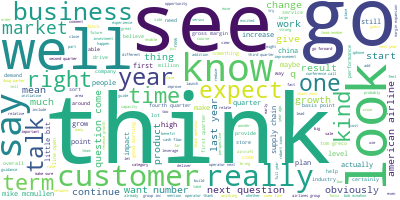

In [6]:
from wordcloud import WordCloud

# create a wordcloud representation of all the documents combined
long_string = ','.join(list(data.values()))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [4]:
import gensim.corpora as corpora

# create a list of words for each document
data_words = [doc.split() for doc in data.values()]

# create a dictionary of all the docs
id2word = corpora.Dictionary(data_words)
texts = data_words

# convert each document to a bag of words
corpus = [id2word.doc2bow(text) for text in texts]

# print first 30 words and their frequency
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 9), (9, 1), (10, 2), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 3), (17, 1), (18, 1), (19, 2), (20, 1), (21, 2), (22, 4), (23, 2), (24, 5), (25, 1), (26, 31), (27, 96), (28, 3), (29, 1)]


In [5]:
from pprint import pprint
import gensim

# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())

[(0,
  '0.042*"the" + 0.027*"to" + 0.024*"in" + 0.023*"of" + 0.022*"and" + '
  '0.017*"we" + 0.015*"a" + 0.015*"that" + 0.015*"our" + 0.010*"for"'),
 (1,
  '0.044*"the" + 0.029*"to" + 0.023*"and" + 0.019*"of" + 0.019*"we" + '
  '0.017*"a" + 0.017*"in" + 0.015*"our" + 0.015*"that" + 0.010*"is"'),
 (2,
  '0.039*"the" + 0.030*"to" + 0.030*"of" + 0.026*"and" + 0.018*"that" + '
  '0.016*"we" + 0.016*"our" + 0.015*"in" + 0.012*"a" + 0.010*"for"'),
 (3,
  '0.046*"the" + 0.024*"to" + 0.023*"of" + 0.021*"and" + 0.021*"in" + '
  '0.020*"we" + 0.017*"a" + 0.013*"our" + 0.013*"that" + 0.012*"is"')]


In [6]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# create the data visualization
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

# save as html
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

e:\Ebay_K\Top2Vec\venv\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
e:\Ebay_K\Top2Vec\venv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.000742  0.002215       1        1  27.777737
2     -0.003099 -0.000149       2        1  26.351220
0      0.000500 -0.001274       3        1  24.429568
3      0.001857 -0.000792       4        1  21.441474, topic_info=       Term          Freq         Total Category  logprob  loglift
1381     in  17777.000000  17777.000000  Default  30.0000  30.0000
1689     of  22532.000000  22532.000000  Default  29.0000  29.0000
2292    the  40338.000000  40338.000000  Default  28.0000  28.0000
563       a  14352.000000  14352.000000  Default  27.0000  27.0000
2435     we  16930.000000  16930.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
1200    for   1494.510805   8322.580600   Topic4  -4.9078  -0.1773
2312  think    755.572917   3600.536363   Topic4  -5.5898  -0.0215
1306   have    960.167827   5272.755125   Topic4  -5.3502  -0.1634
1215   from    778.053878   4107.942879   Topic4  -5.5605  -0.1240
1440     it    738.296953   4071.178233   Topic4  -5.6130  -0.1675

[373 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
12624      1  0.340171  $17.4
12624      2  0.340171  $17.4
12624      3  0.340171  $17.4
12624      4  0.340171  $17.4
25569      1  0.339527  $53.3
...      ...       ...    ...
8475       4  0.158906    ’18
8476       1  0.344996   ’18,
8476       2  0.344996   ’18,
8476       3  0.344996   ’18,
8476       4  0.344996   ’18,

[972 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])